# Word Segmentation on Xitsonga

Copyright (c) 2021 Herman Kamper, MIT License

Train a segmental autoencoding recurrent neural network (segmental AE-RNN) and perform word segmentation on encoded Xitsonga.

## Preliminaries

In [1]:
from datetime import datetime
from pathlib import Path
from scipy.stats import gamma
from sklearn import cluster
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
import torch.nn as nn

sys.path.append("..")

from seg_aernn import datasets, models, viterbi
from utils import eval_segmentation

## Utility functions

In [2]:
def get_segmented_sentence(ids, boundaries):
    output = ""
    cur_word = []
    for i_symbol, boundary in enumerate(boundaries):
        cur_word.append(id_to_symbol[ids[i_symbol]])
        if boundary:
            output += "_".join(cur_word)
            output += " "
            cur_word = []
    return output.strip()

In [3]:
# Duration penalty functions

# Histogram
histogram = np.array([
    0, 1.66322800e-01, 2.35838129e-01, 2.10609187e-01,
    1.48025482e-01, 9.42918160e-02, 5.84211098e-02, 3.64679480e-02,
    2.18264741e-02, 1.25420784e-02, 7.18500018e-03, 4.27118399e-03,
    1.73743077e-03, 1.19448366e-03, 7.42027726e-04, 2.89571796e-04,
    2.35277084e-04, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001
    ])  # to-do: check this
histogram = histogram/np.sum(histogram)
def neg_log_hist(dur):
    return -np.log(0 if dur >= len(histogram) else histogram[dur])

# Cached Gamma
# shape, loc, scale = (2.3, 0, 1.3)  # VQ-VAE
shape, loc, scale = (2.6, 0, 1.8)    # CPC-big
# shape, loc, scale = (2.5, 0, 1.5)    # CPC-big (Gamma)
gamma_cache = []
for dur in range(200):
    gamma_cache.append(gamma.pdf(dur, shape, loc, scale))
gamma_cache = np.array(gamma_cache)/np.sum(gamma_cache)
def neg_log_gamma(dur):
    if dur < 200:
        return -np.log(gamma_cache[dur])
    else:
        return -np.log(0)
    
# Chorowski
def neg_chorowski(dur):
    return -(dur - 1)

## Data

In [4]:
# Dataset
vq_model = "cpc_big"
# vq_model = "xlsr"
dataset = "xitsonga"
split = "train"
seg_tag = "phoneseg_dp_penalized"

# Paths
seg_dir = (
    Path("../../vqwordseg/exp")/vq_model/dataset/split/seg_tag/"intervals"
    )
word_ref_dir = Path("../../vqwordseg/data")/dataset/"word_intervals"

In [5]:
# Read phone segmentation
phoneseg_interval_dict = {}
print("Reading: {}".format(seg_dir))
phoneseg_interval_dict = eval_segmentation.get_intervals_from_dir(seg_dir)
utterances = phoneseg_interval_dict.keys()

  0%|          | 10/4058 [00:00<00:42, 95.01it/s]

Reading: ../../vqwordseg/exp/cpc_big/xitsonga/train/phoneseg_dp_penalized/intervals


100%|██████████| 4058/4058 [00:39<00:00, 103.24it/s]


In [6]:
# Read word reference
print("Reading: {}".format(word_ref_dir))
word_ref_interval_dict = eval_segmentation.get_intervals_from_dir(word_ref_dir, utterances)

  0%|          | 1/4058 [00:00<06:47,  9.96it/s]

Reading: ../../vqwordseg/data/xitsonga/word_intervals


100%|██████████| 4058/4058 [00:58<00:00, 69.35it/s]


In [7]:
word_types = set()
for utt_key in tqdm(word_ref_interval_dict):
    for start, end, label in word_ref_interval_dict[utt_key]:
        word_types.add(label)
print("No. word types:", len(word_types))

100%|██████████| 4058/4058 [00:00<00:00, 877299.40it/s]

No. word types: 2288


In [8]:
# Convert intervals to boundaries
word_ref_boundaries_dict = {}
for utt_key in tqdm(word_ref_interval_dict):
    word_ref_boundaries_dict[utt_key] = eval_segmentation.intervals_to_boundaries(
        word_ref_interval_dict[utt_key]
        )

100%|██████████| 4058/4058 [00:00<00:00, 283740.97it/s]


In [9]:
prepared_text = []
for utt_key in tqdm(utterances):
    prepared_text.append(
        "_".join([i[2] for i in phoneseg_interval_dict[utt_key]])
        )
print(prepared_text[0])

100%|██████████| 4058/4058 [00:00<00:00, 404787.04it/s]

13_15_9_44_14_1_34_18_6_44_14_24_5_37_20_9_44_32_46_14_1_10_44_14_24_5_40_47_15_6_44_14_1_21_25_36_39_47_24_15_41_44_14_47_24_29_36_40_33_44_25_14_17_40_14_47_24_15_27_23_17_27_38


In [10]:
# Gold segmentation, where boundaries are inserted in best possible positions
n_not_in_tolerance = 0
prepared_text_gold = []
for utt_key in tqdm(utterances):
    seg_intervals = phoneseg_interval_dict[utt_key].copy()
    ref_intervals = word_ref_interval_dict[utt_key].copy()
    seg_boundaries = np.array([i[1] - 1 for i in seg_intervals])
    ref_boundaries = np.array([i[1] - 1 for i in ref_intervals])
    for ref_boundary in ref_boundaries[:-1]:
        i_seg = np.argmin(np.abs(seg_boundaries - ref_boundary))
        seg_intervals.insert(
            i_seg + 1, (seg_intervals[i_seg][1], seg_intervals[i_seg][1], " ")
            )
        seg_boundaries = np.array([i[1] - 1 for i in seg_intervals])
    cur_text_gold = ""
    for start, end, label in seg_intervals:
        if label == " ":
            cur_text_gold = cur_text_gold[:-1]
            cur_text_gold += " "
        else:
            cur_text_gold += label + "_"
    cur_text_gold = cur_text_gold[:-1]
    prepared_text_gold.append(cur_text_gold)

print(prepared_text_gold[0])

100%|██████████| 4058/4058 [00:00<00:00, 16435.23it/s]

13_15_9_44_14_1_34_18_6_44_14 24_5 37_20_9_44_32_46 14_1_10_44_14 24_5_40 47_15_6_44_14_1_21_25 36_39_47_24_15_41_44_14 47_24_29_36_40_33_44_25 14_17_40_14_47_24_15_27_23_17_27_38


No. word types: 15107
Mean training word length: 8.3187
Min training word length:  1
Max training word length:  36
Mean: 8.318743381574302
Gamma parameters: 2.457785860462573 0 3.3846493770651986


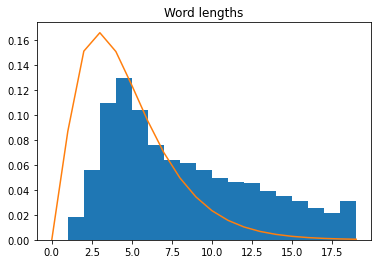

In [11]:
# Training word length statistics
word_lengths = []
n_words = []
word_types = set()
for sentence in prepared_text_gold:
    word_lengths.extend([len(i.split("_")) for i in sentence.split(" ")])
    n_words.append(len(sentence.split(" ")))
    for word in sentence.split(" "):
        word_types.add(word)
#     word_lengths.extend([len(i.replace("$", "")) for i in sentence.split(" ")])  # temp
print("No. word types:", len(word_types))
print("Mean training word length: {:.4f}".format(np.mean(word_lengths)))
print("Min training word length:  {:d}".format(np.min(word_lengths)))
print("Max training word length:  {:d}".format(np.max(word_lengths)))

# Histogram
plt.figure()
n, bins, patches = plt.hist(word_lengths, bins=range(20), density=True)
plt.title("Word lengths")

# Gamma
mean = np.mean(word_lengths)
var  = np.var(word_lengths)
alpha = (mean**2)/var
beta  = alpha / mean
shape = alpha
loc = 0
scale = 1/beta
print("Mean:", mean)
print("Gamma parameters:", shape, loc, scale)
shape, loc, scale = (2.6, 0, 1.8)
plt.plot(bins, gamma.pdf(bins, shape, loc, scale))

plt.show();

In [12]:
# Vocabulary
PAD_SYMBOL      = "<pad>"
SOS_SYMBOL      = "<s>"    # start of sentence
EOS_SYMBOL      = "</s>"   # end of sentence
BOUNDARY_SYMBOL = " "      # word boundary
symbols = set()
for sentence in prepared_text:
    for char in sentence.split("_"):
        symbols.add(char)
SYMBOLS = [PAD_SYMBOL, SOS_SYMBOL, EOS_SYMBOL, BOUNDARY_SYMBOL] + (sorted(list(symbols)))
symbol_to_id = {s: i for i, s in enumerate(SYMBOLS)}
id_to_symbol = {i: s for i, s in enumerate(SYMBOLS)}

def text_to_id(text, add_sos_eos=False):
    """
    Convert text to a list of symbol IDs.

    Sentence start and end symbols can be added by setting `add_sos_eos`.
    """
    symbol_ids = []
    for word in text.split(" "):
        for code in word.split("_"):
            symbol_ids.append(symbol_to_id[code])
        symbol_ids.append(symbol_to_id[BOUNDARY_SYMBOL])
    symbol_ids = symbol_ids[:-1]  # remove last space

    if add_sos_eos:
        return [symbol_to_id[SOS_SYMBOL]] + symbol_ids + [symbol_to_id[EOS_SYMBOL]]
    else:
        return symbol_ids

print(text_to_id(prepared_text[0]))
print([id_to_symbol[i] for i in text_to_id(prepared_text[0])])

[9, 11, 53, 43, 10, 5, 32, 14, 50, 43, 10, 21, 49, 35, 17, 53, 43, 30, 45, 10, 5, 6, 43, 10, 21, 49, 39, 46, 11, 50, 43, 10, 5, 18, 22, 34, 37, 46, 21, 11, 40, 43, 10, 46, 21, 26, 34, 39, 31, 43, 22, 10, 13, 39, 10, 46, 21, 11, 24, 20, 13, 24, 36]
['13', '15', '9', '44', '14', '1', '34', '18', '6', '44', '14', '24', '5', '37', '20', '9', '44', '32', '46', '14', '1', '10', '44', '14', '24', '5', '40', '47', '15', '6', '44', '14', '1', '21', '25', '36', '39', '47', '24', '15', '41', '44', '14', '47', '24', '29', '36', '40', '33', '44', '25', '14', '17', '40', '14', '47', '24', '15', '27', '23', '17', '27', '38']


In [13]:
# First three words of training data
word_dataset = datasets.WordDataset(prepared_text, text_to_id)
for i in range(7):
    sample = word_dataset[i]
    print("_".join([id_to_symbol[i] for i in sample.numpy()]))

13_15_9_44_14_1_34_18_6_44_14_24_5_37_20_9_44_32_46_14_1_10_44_14_24_5_40_47_15_6_44_14_1_21_25_36_39_47_24_15_41_44_14_47_24_29_36_40_33_44_25_14_17_40_14_47_24_15_27_23_17_27_38
13_27_23_40_21_45_14_37_18_20_6_42_49_10_44_14_26_6_44_45_14_47_1_10_27_2_46_40_21_44_16_38
13_20_6_35_47_15_9_11_45_14_33_36_48_14_1_10_44_14_33_44_14_47_24_15_27_23_33_5_43
13_34_24_29_36_0_33_10_27_23_37_18_6_44_25_39_45_14_10_42_47_24_41_44_14_10_21_45_14_10_42_47_24_41_27_47_24_29_42_37_18_20_6_42_25_36_39_2_23_24_29_46
31_24_33_44_45_37_18_20_6_11_2_1_10_46_43_28_1_15_9_44_14_49_34_10_44_45_14_1_10_36_39_14_33_10_27_37_18_20_6_44_45_25_40_34
13_35_23_24_29_36_39_35_46_25_36_39_2_46_14_1_10_25_17_24_5_40_33_34_5_35_23_47_24_40_34
13_24_5_27_16_20_9_27_23_49_10_45_14_37_18_20_27_46_17_36_39_14_47_24_15_27_46_37_18_20_6_21_42_37_18_20_9_44_45


In [14]:
# Data

# Approximate ground truth (for debugging)
# cur_train_sentences = prepared_text_gold[:10000]
cur_val_sentences = prepared_text_gold[-100:]

# No boundaries
# cur_train_sentences = prepared_text[:10000]
cur_train_sentences = prepared_text

# Random boundaries
np.random.seed(42)
# cur_train_sentences = insert_random_boundaries(cur_train_sentences)
# cur_val_sentences = insert_random_boundaries(cur_val_sentences)

print("No. train sentences:", len(cur_train_sentences))
print("Examples:", cur_train_sentences[:3])
print("Min length: ", min([len(i.split("_")) for i in cur_train_sentences]))
print("Max length: ", max([len(i.split("_")) for i in cur_train_sentences]))
print("Mean length: {:.4f}".format(np.mean([len(i.split("_")) for i in cur_train_sentences])))

No. train sentences: 4058
Examples: ['13_15_9_44_14_1_34_18_6_44_14_24_5_37_20_9_44_32_46_14_1_10_44_14_24_5_40_47_15_6_44_14_1_21_25_36_39_47_24_15_41_44_14_47_24_29_36_40_33_44_25_14_17_40_14_47_24_15_27_23_17_27_38', '13_27_23_40_21_45_14_37_18_20_6_42_49_10_44_14_26_6_44_45_14_47_1_10_27_2_46_40_21_44_16_38', '13_20_6_35_47_15_9_11_45_14_33_36_48_14_1_10_44_14_33_44_14_47_24_15_27_23_33_5_43']
Min length:  4
Max length:  96
Mean length: 40.6528


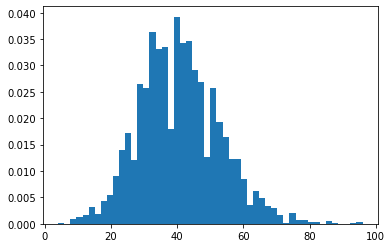

In [15]:
plt.hist([len(i.split("_")) for i in cur_train_sentences], 50, density=True)
plt.show()

## Model

In [16]:
# AE-RNN model
n_symbols = len(SYMBOLS)
symbol_embedding_dim = 10  # 25
hidden_dim = 500  # 250  # 500  # 1000  # 200
embedding_dim = 50  # 150  # 300  # 25
teacher_forcing_ratio = 0.5  # 1.0  # 0.5  # 1.0
n_encoder_layers = 1  # 1  # 3  # 10
n_decoder_layers = 1  # 1  # 1
batch_size = 32  # 32*3  # 32
learning_rate = 0.001
input_dropout = 0.0  # 0.0 # 0.5
dropout = 0.0
n_symbols_max = 50  # test
# n_epochs_max = 5
n_epochs_max = None  # determined from n_max_steps and batch size
n_steps_max = 1500  # 2500  # 1500  # 1000  # None
# n_steps_max = None  # Only use n_epochs_max
bidirectional_encoder = False  # False

encoder = models.Encoder(
    n_symbols=n_symbols,
    symbol_embedding_dim=symbol_embedding_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    n_layers=n_encoder_layers,
    dropout=dropout,
    input_dropout=input_dropout,
    bidirectional=bidirectional_encoder
    )
# decoder = models.Decoder1(
#     n_symbols=n_symbols,
#     symbol_embedding_dim=symbol_embedding_dim,
#     hidden_dim=hidden_dim,
#     embedding_dim=embedding_dim,
#     n_layers=n_decoder_layers,
#     sos_id = symbol_to_id[SOS_SYMBOL],
#     teacher_forcing_ratio=teacher_forcing_ratio,
#     dropout=dropout
#     )
decoder = models.Decoder2(
    n_symbols=n_symbols,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    n_layers=n_decoder_layers,
    dropout=dropout
    )
model = models.EncoderDecoder(encoder, decoder)

## Pre-training

In [17]:
# Training device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Training data
train_dataset = datasets.WordDataset(
    cur_train_sentences, text_to_id, n_symbols_max=n_symbols_max
    )
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=datasets.pad_collate
    )

# Validation data
val_dataset = datasets.WordDataset(cur_val_sentences, text_to_id)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=datasets.pad_collate
    )

# Loss
criterion = nn.NLLLoss(
    reduction="sum", ignore_index=symbol_to_id[PAD_SYMBOL]
    )
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

if n_epochs_max is None:
    steps_per_epoch = np.ceil(len(cur_train_sentences)/batch_size)
    n_epochs_max = int(np.ceil(n_steps_max/steps_per_epoch))

i_step = 0
for i_epoch in range(n_epochs_max):

    # Training
    model.train()
    train_losses = []
    for i_batch, (data, data_lengths) in enumerate(tqdm(train_loader)):
        optimiser.zero_grad()
        data = data.to(device)       
        encoder_embedding, decoder_output = model(
            data, data_lengths, data, data_lengths
            )

        loss = criterion(
            decoder_output.contiguous().view(-1, decoder_output.size(-1)),
            data.contiguous().view(-1)
            )
        loss /= len(data_lengths)
        loss.backward()
        optimiser.step()
        train_losses.append(loss.item())
        i_step += 1
        if i_step == n_steps_max and n_steps_max is not None:
            break

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for i_batch, (data, data_lengths) in enumerate(val_loader):
            data = data.to(device)            
            encoder_embedding, decoder_output = model(
                data, data_lengths, data, data_lengths
                )

            loss = criterion(
                decoder_output.contiguous().view(-1,
                decoder_output.size(-1)), data.contiguous().view(-1)
                )
            loss /= len(data_lengths)
            val_losses.append(loss.item())
    
    print(
        "Epoch {}, train loss: {:.3f}, val loss: {:.3f}".format(
        i_epoch,
        np.mean(train_losses),
        np.mean(val_losses))
        )
    sys.stdout.flush()

    if i_step == n_steps_max and n_steps_max is not None:
        break

100%|██████████| 127/127 [00:03<00:00, 31.87it/s]


Epoch 0, train loss: 137.541, val loss: 29.130


100%|██████████| 127/127 [00:04<00:00, 31.42it/s]

Epoch 1, train loss: 132.255, val loss: 28.237



100%|██████████| 127/127 [00:04<00:00, 30.97it/s]


Epoch 2, train loss: 129.908, val loss: 26.745


100%|██████████| 127/127 [00:04<00:00, 30.39it/s]


Epoch 3, train loss: 127.428, val loss: 25.868


100%|██████████| 127/127 [00:04<00:00, 30.66it/s]

Epoch 4, train loss: 125.089, val loss: 25.356



100%|██████████| 127/127 [00:04<00:00, 30.71it/s]


Epoch 5, train loss: 122.971, val loss: 24.412


100%|██████████| 127/127 [00:04<00:00, 31.26it/s]

Epoch 6, train loss: 121.024, val loss: 23.768



100%|██████████| 127/127 [00:04<00:00, 29.23it/s]


Epoch 7, train loss: 118.827, val loss: 23.260


100%|██████████| 127/127 [00:04<00:00, 31.54it/s]

Epoch 8, train loss: 116.190, val loss: 22.954



100%|██████████| 127/127 [00:04<00:00, 31.58it/s]

Epoch 9, train loss: 114.207, val loss: 22.279



100%|██████████| 127/127 [00:03<00:00, 31.80it/s]

Epoch 10, train loss: 112.498, val loss: 23.520



 80%|████████  | 102/127 [00:03<00:00, 31.02it/s]


Epoch 11, train loss: 111.077, val loss: 21.798


In [18]:
# Examples without segmentation

# Apply to validation data
model.eval()
with torch.no_grad():
    for i_batch, (data, data_lengths) in enumerate(val_loader):
        data = data.to(device)
        encoder_embedding, decoder_output = model(
            data, data_lengths, data, data_lengths
            )
        
        y, log_probs = model.decoder.greedy_decode(
            encoder_embedding,
            max_length=25,
            )
        x = data.cpu().numpy()
        
        for i_input in range(y.shape[0]):
            # Only print up to EOS symbol
            input_symbols = []
            for i in x[i_input]:
                if i == symbol_to_id[EOS_SYMBOL] or i == symbol_to_id[PAD_SYMBOL]:
                    break
                input_symbols.append(id_to_symbol[i])
            output_symbols = []
            for i in y[i_input]:
                if i == symbol_to_id[EOS_SYMBOL] or i == symbol_to_id[PAD_SYMBOL]:
                    break
                output_symbols.append(id_to_symbol[i])

            print("Input: ", "_".join(input_symbols))
            print("Output:", "_".join(output_symbols))
            print()
            
            if i_input == 10:
                break
        
        break

Input:  2_46
Output: 46_46_46_46_46_23_23_23_23_23_23_23_19_19_19_46_46_46_46_46_46_46_46_46_23

Input:  47_24_15_35_49_34_18_20_6_35_23_33_34_38
Output: 13_20_20_6_35_37_37_20_9_35_35_38_38_38_38_38_38_38_38_38_38_38_35_35_23

Input:  1_10_27_23
Output: 13_27_27_27_27_23_23_23_23_23_23_23_23_23_23_23_23_27_27_27_23_23_23_23_23

Input:  26_5_27_23_47_24_29_44_0_14_38
Output: 13_29_39_14_47_24_24_29_44_44_44_38_38_38_38_38_38_38_38_38_38_38_38_38_38

Input:  27_46_25
Output: 27_27_46_46_25_25_25_25_25_25_25_25_25_25_25_25_25_25_25_25_27_27_27_27_46

Input:  13_27_37_26_5_44_0_14_33_36_32_14
Output: 13_33_14_14_14_44_44_25_25_25_40_14_34_34_40_40_12_12_12_12_13_13_34_34_34

Input:  43_28_14_1_34_15_41_44
Output: 13_28_41_14_14_14_14_43_45_38_38_38_38_13_13_28_14_14_14_14_14_43_43_38_38

Input:  17_24_36
Output: 13_36_36_17_17_24_36_36_36_36_36_36_36_36_36_36_36_36_36_36_36_36_36_36_36

Input:  17_36_39_35_23_1_10
Output: 13_1_39_1_1_1_1_1_1_1_1_38_38_38_38_38_34_1_1_1_1_1_1_1_1

Input:  

## Segmentation

In [19]:
# Utterances for evaluation
n_eval_utterances = len(prepared_text)  # 1000  # 10000  # 1000
# eval_sentences = prepared_text[-n_eval_utterances:]  # val sentences
# eval_utterances = list(utterances)[-n_eval_utterances:]
eval_sentences = prepared_text[:n_eval_utterances]
eval_utterances = list(utterances)[:n_eval_utterances]

In [20]:
# Embed segments

# Random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Data
sentences = eval_sentences
# sentences = cur_val_sentences
interval_dataset = datasets.SentenceIntervalDataset(
    sentences,
    text_to_id,
    join_char="_"
    )
segment_loader = DataLoader(
    interval_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=datasets.pad_collate,
    drop_last=False
    )

# Apply model to data
model.decoder.teacher_forcing_ratio = 1.0
model.eval()
rnn_losses = []
lengths = []
eos = []
with torch.no_grad():
    for i_batch, (data, data_lengths) in enumerate(tqdm(segment_loader)):
        data = data.to(device)
        
        encoder_embedding, decoder_output = model(
            data, data_lengths, data, data_lengths
            )

        for i_item in range(data.shape[0]):
            item_loss = criterion(
                decoder_output[i_item].contiguous().view(-1,
                decoder_output[i_item].size(-1)),
                data[i_item].contiguous().view(-1)
                )
            rnn_losses.append(item_loss.cpu().numpy())
            lengths.append(data_lengths[i_item])

100%|██████████| 64023/64023 [06:47<00:00, 157.22it/s]


In [46]:
# Segment

dur_weight = 3.0  # 3.0

i_item = 0
losses = []
cur_segmented_sentences = []
for i_sentence, intervals in enumerate(tqdm(interval_dataset.intervals)):
    
    # Costs for segment intervals
    costs = np.inf*np.ones(len(intervals))
    i_eos = intervals[-1][-1]
    for i_seg, interval in enumerate(intervals):
        if interval is None:
            continue
        i_start, i_end = interval
        dur = i_end - i_start
        assert dur == lengths[i_item]
        eos = (i_end == i_eos)  # end-of-sequence
        
        # Chorowski
        costs[i_seg] = (
            rnn_losses[i_item]
            + dur_weight*neg_chorowski(dur)
            )
        
#         # Gamma
#         costs[i_seg] = (
#             rnn_losses[i_item]
#             + dur_weight*neg_log_gamma(dur)
#             + np.log(np.sum(gamma_cache**dur_weight))
#             )
        
#         # Poisson
#         costs[i_seg] = (
#             rnn_losses[i_item]
#             + neg_log_poisson(dur)
#             )

#         # Histogram
#         costs[i_seg] = (
#             rnn_losses[i_item]
#             + dur_weight*(neg_log_hist(dur))
#             + np.log(np.sum(histogram**dur_weight))
#             )
    
#         # Sequence boundary
#         alpha = 0.3  # 0.3  # 0.9
#         if eos:
#             costs[i_seg] += -np.log(alpha)
#         else:
#             costs[i_seg] += -np.log(1 - alpha)
# #             K = 5000
# #             costs[i_seg] += -np.log((1 - alpha)/K)

        # Temp
#         if dur > 10 or dur <= 1:
#             costs[i_seg] = +np.inf
        i_item += 1
    
    # Viterbi segmentation
    n_frames = len(interval_dataset.sentences[i_sentence])
    summed_cost, boundaries = viterbi.custom_viterbi(costs, n_frames)
    losses.append(summed_cost)
    
    reference_sentence = sentences[i_sentence]
    segmented_sentence = get_segmented_sentence(
            interval_dataset.sentences[i_sentence],
            boundaries
            )
    cur_segmented_sentences.append(segmented_sentence)
#     # Print examples of the first few sentences
#     if i_sentence < 10:
#         print(reference_sentence)
#         print(segmented_sentence)
#         print()
    
print("NLL: {:.4f}".format(np.sum(losses)))

100%|██████████| 4058/4058 [00:04<00:00, 957.25it/s] 

NLL: -91210.4204


## Evaluation

In [47]:
print(cur_segmented_sentences[0])

# # To evaluate gold segmentation:
# cur_segmented_sentences = prepared_text_gold[:n_eval_utterances]
# print(cur_segmented_sentences[0])

13_15_9_44_14_1_34_18_6_44_14 24_5_37_20_9_44_32_46_14_1_10_44_14 24_5_40 47_15_6_44 14_1_21 25_36_39_47_24_15_41_44_14_47_24_29_36 40_33_44_25_14_17_40_14_47_24_15_27_23 17_27_38


In [48]:
# Convert segmentation to intervals
segmentation_interval_dict = {}
for i_utt, utt_key in tqdm(enumerate(eval_utterances)):
    words_segmented = cur_segmented_sentences[i_utt].split(" ")
    word_start = 0
    word_label = ""
    i_word = 0
    segmentation_interval_dict[utt_key] = []
    for (phone_start, phone_end,
            phone_label) in phoneseg_interval_dict[utt_key]:
        word_label += phone_label + "_"
        if words_segmented[i_word] == word_label[:-1]:
            segmentation_interval_dict[utt_key].append((
                word_start, phone_end, word_label[:-1]
                ))
            word_label = ""
            word_start = phone_end
            i_word += 1

    if i_utt < 10:
        print(segmentation_interval_dict[utt_key])
        print(word_ref_interval_dict[utt_key])
        print()        

4058it [00:00, 61935.24it/s]

[(0, 40, '13_15_9_44_14_1_34_18_6_44_14'), (40, 110, '24_5_37_20_9_44_32_46_14_1_10_44_14'), (110, 122, '24_5_40'), (122, 143, '47_15_6_44'), (143, 156, '14_1_21'), (156, 201, '25_36_39_47_24_15_41_44_14_47_24_29_36'), (201, 270, '40_33_44_25_14_17_40_14_47_24_15_27_23'), (270, 290, '17_27_38')]
[(0, 40, 'dyondza'), (40, 52, 'ku'), (52, 91, 'hlaya'), (91, 109, 'na'), (109, 124, 'ku'), (124, 161, 'tsala'), (161, 187, 'uta'), (187, 220, 'kuma'), (220, 290, 'vutivi')]

[(0, 21, '13_27'), (21, 121, '23_40_21_45_14_37_18_20_6_42_49_10_44_14_26'), (121, 137, '6_44_45_14'), (137, 209, '47_1_10_27_2_46_40_21_44_16_38')]
[(0, 24, 'hi'), (24, 63, 'laha'), (63, 85, 'swi'), (85, 109, 'nga'), (109, 209, 'fanela')]

[(0, 76, '13_20_6_35_47_15_9_11_45_14_33_36_48'), (76, 93, '14_1_10_44'), (93, 178, '14_33_44_14_47_24_15_27_23_33_5_43')]
[(0, 78, 'swicelwa'), (78, 95, 'ni'), (95, 179, 'matimba')]

[(0, 14, '13_34'), (14, 34, '24_29_36_0'), (34, 106, '33_10_27_23_37_18_6_44_25_39_45_14_10_42_47'), (10

In [49]:
# Intervals to boundaries
segmentation_boundaries_dict = {}
for utt_key in tqdm(segmentation_interval_dict):
    segmentation_boundaries_dict[utt_key] = eval_segmentation.intervals_to_boundaries(
        segmentation_interval_dict[utt_key]
        )
word_ref_boundaries_dict = {}
for utt_key in tqdm(word_ref_interval_dict):
    word_ref_boundaries_dict[utt_key] = eval_segmentation.intervals_to_boundaries(
        word_ref_interval_dict[utt_key]
        )

# Evaluate word boundaries
reference_list = []
segmentation_list = []
for utterance in segmentation_boundaries_dict:
    reference_list.append(word_ref_boundaries_dict[utterance])
    segmentation_list.append(segmentation_boundaries_dict[utterance])

tolerance = 2
p, r, f = eval_segmentation.score_boundaries(
    reference_list, segmentation_list, tolerance=tolerance
    )
print("-"*(79 - 4))
print("Word boundaries:")
print("Precision: {:.2f}%".format(p*100))
print("Recall: {:.2f}%".format(r*100))
print("F-score: {:.2f}%".format(f*100))
print("OS: {:.2f}%".format(eval_segmentation.get_os(p, r)*100))
print("R-value: {:.2f}%".format(eval_segmentation.get_rvalue(p, r)*100))
print("-"*(79 - 4))

p, r, f = eval_segmentation.score_word_token_boundaries(
    reference_list, segmentation_list, tolerance=tolerance
    )
print("Word token boundaries:")
print("Precision: {:.2f}%".format(p*100))
print("Recall: {:.2f}%".format(r*100))
print("F-score: {:.2f}%".format(f*100))
print("OS: {:.2f}%".format(eval_segmentation.get_os(p, r)*100))
# print("R-value: {:.2f}%".format(get_rvalue(p, r)*100))
print("-"*(79 - 4))

100%|██████████| 4058/4058 [00:00<00:00, 247588.71it/s]


---------------------------------------------------------------------------
Word boundaries:
Precision: 20.59%
Recall: 19.75%
F-score: 20.16%
OS: -4.06%
R-value: 32.89%
---------------------------------------------------------------------------
Word token boundaries:
Precision: 6.34%
Recall: 6.14%
F-score: 6.24%
OS: -3.20%
---------------------------------------------------------------------------


In [50]:
# Write intervals to a directory
output_tag = "wordseg_segaernn_{}".format(seg_tag.replace("phoneseg_", ""))
output_dir = (
    Path("../../vqwordseg/exp")/vq_model/dataset/split/output_tag/"intervals"
    )
output_dir.mkdir(exist_ok=True, parents=True)
print(f"Writing to: {output_dir}")
for utt_key in tqdm(segmentation_interval_dict):
    with open((output_dir/utt_key).with_suffix(".txt"), "w") as f:
        for (i_segment, (start, end, label)) in enumerate(segmentation_interval_dict[utt_key]):
#             label = cluster_dict[utt_key][i_segment]
            f.write(f"{start:d} {end:d} {label}_\n")
            
#         for start, end, label in segmentation_interval_dict[utt_key]:
# #             f.write(f"{start:d} {end:d} {label}\n")
#             f.write(f"{start:d} {end:d} {label}_\n")

 28%|██▊       | 1138/4058 [00:00<00:00, 11329.82it/s]

Writing to: ../../vqwordseg/exp/cpc_big/xitsonga/train/wordseg_segaernn_dp_penalized/intervals


100%|██████████| 4058/4058 [00:00<00:00, 10538.84it/s]
